# Collisional model

This notebook reproduces the results of Fig. 2 in the paper, using the circuits described in Fig. 7.

The notebook is divided in different sections:

1. [Circuit preparation](#circuit_preparation) where the circuits are prepared 
2. [Simulation](#simulation) where they are simulated locally
3. [Execution on the real device](#execution) where the jobs are sent for execution on the IBM Q devices
4. [Analysis of the result](#analysis) where the results are collected and the plot is made

This notebook was tested with qiskit 0.12.1 and Python 3.7.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.ignis.verification.tomography import StateTomographyFitter

# Calibration
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

# Utility functions
from qiskit.tools.qi.qi import partial_trace
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

In [2]:
# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [3]:
# We use ibmqx2 and ibmq_16_melbourne
IBMQ.load_account()
ibmqx2 = IBMQ.get_provider().get_backend('ibmqx2')
ibmq_16_melbourne = IBMQ.get_provider().get_backend('ibmq_16_melbourne')

# Local simulator and vector simulator
simulator = Aer.get_backend('qasm_simulator')
vector_backend = Aer.get_backend('statevector_simulator')

### 1. Circuit preparation <a id='circuit_preparation'></a>

First we prepare the circuits for the ancillas on the correlated state

In [4]:
from collisional_model import collisional_model, coherence

SHOTS = 8192

# We create the quantum circuit
q = QuantumRegister(5, name='q')
c = ClassicalRegister(1, name='c')

# Parameters for the model
nmax = 7        # Number of collisions
g = 1.           # Coupling strength
tau = np.pi / 6 # Time constant

# Index of the system qubit
system_corr = 3

# Indices of the ancillary qubits
ancillae_corr = [4, 2, 0]

correlated_circuits =  [collisional_model(q, system_corr, ancillae_corr, 
                               i, g=g, tau=tau, 
                               environment_qubits=2, measure=True, 
                               environment_state='ghz') 
               for i in range(nmax)]

# Ancillaes prepared in the separable plus state
# We create the quantum circuit
qm = QuantumRegister(14, name='q')
cm = ClassicalRegister(1, name='c')

system_sep = 8

# Only the first three ancillas are neighbors of the system
ancillae_sep = [6, 9, 7, 3, 4, 10, 11]

separable_circuits = [collisional_model(qm, system_sep, ancillae_sep, 
                               i, g=g, tau=tau, 
                               environment_qubits=7, measure=True, 
                               environment_state='plus') 
               for i in range(nmax)]

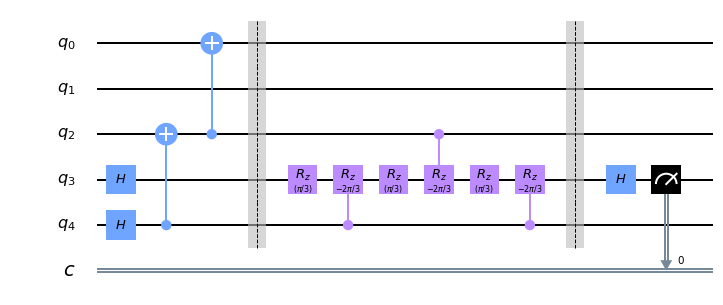

In [5]:
correlated_circuits[3].draw(output='mpl')

Drawing of the circuit with three collisions, with measurement on the `x` basis.

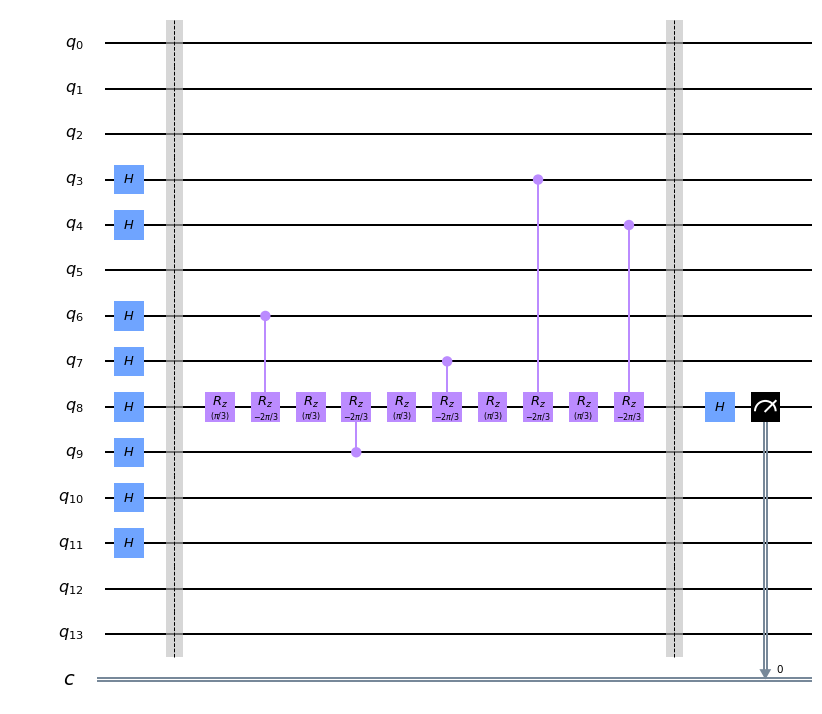

In [6]:
separable_circuits[5].draw(output='mpl')

The above is the circuit with five collisions in the $+$ case. But due to the connectivity map of the real device, the compiled circuit is different: 

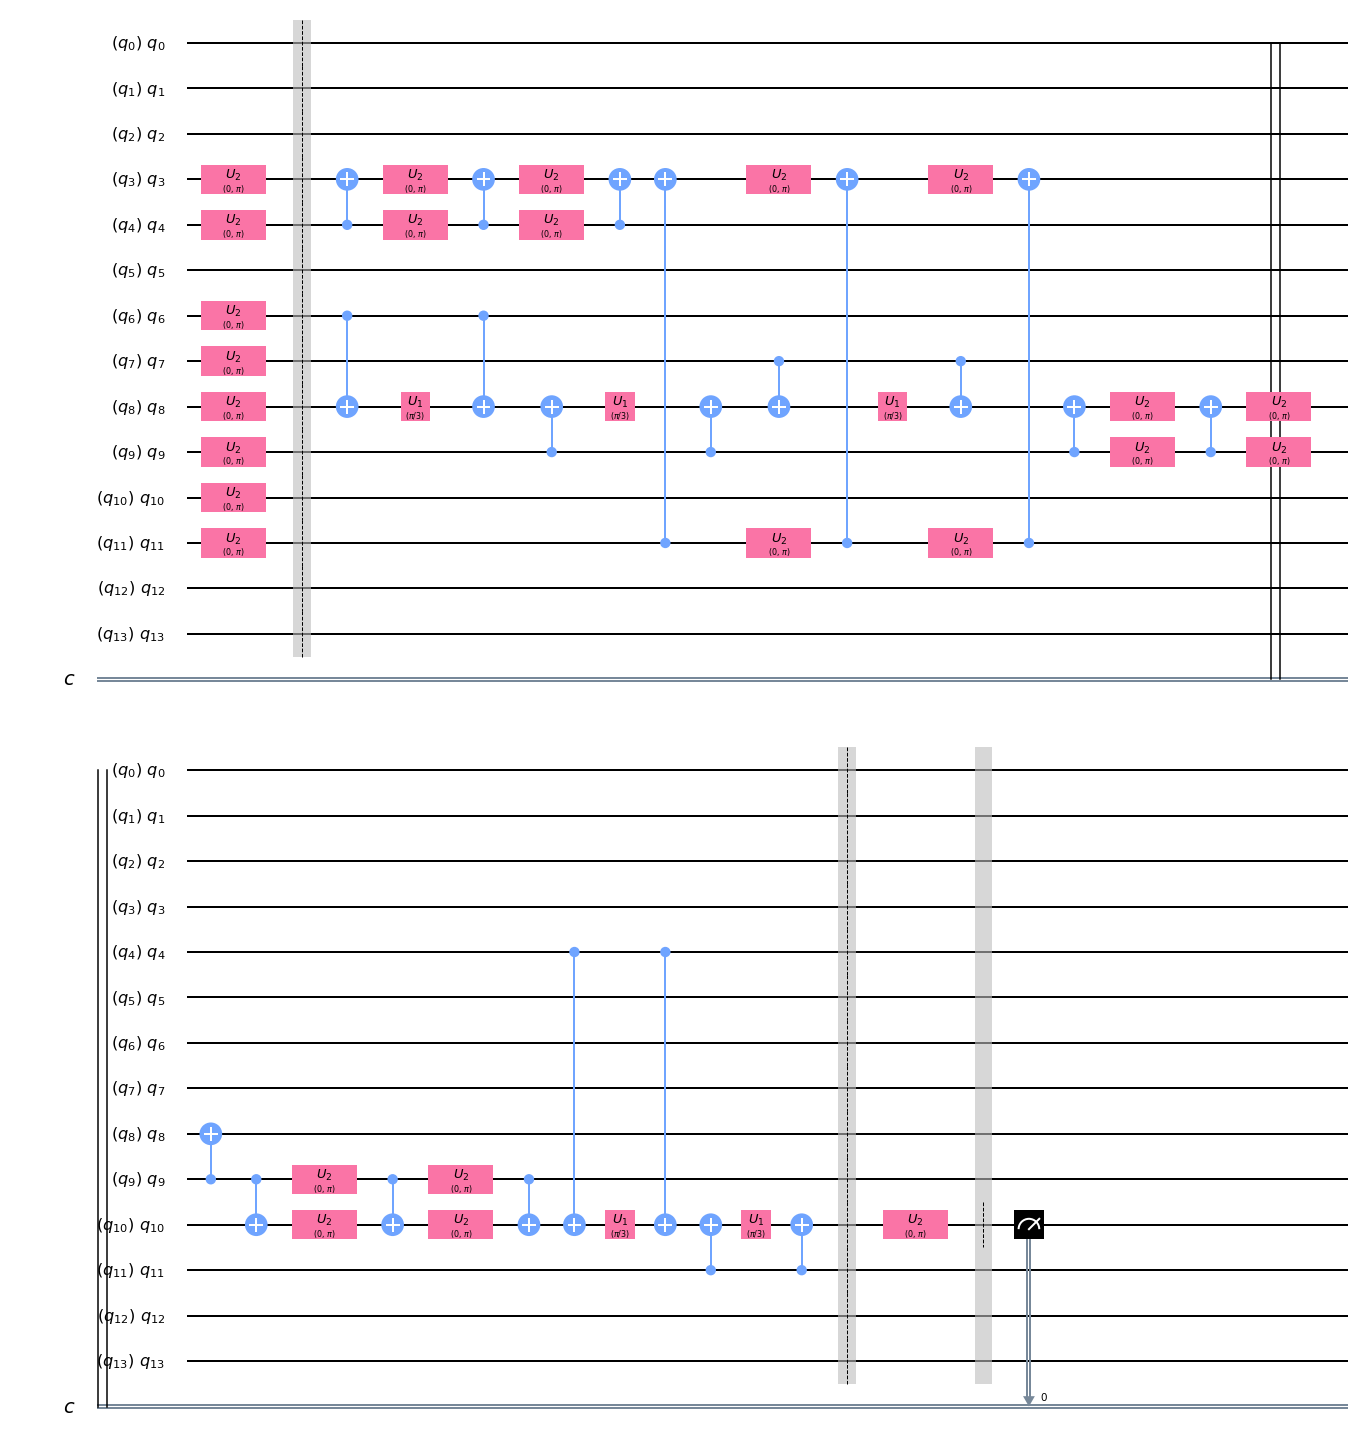

In [7]:
from qiskit import transpile
transpile(separable_circuits[5], backend=ibmq_16_melbourne, optimization_level=1).draw(output='mpl')

Notice that the system qubit is moved to qubit 10.

### 2. Simulation <a id="simulation"/>

This cell executes locally the (noiseless) simulation of the circuits above.

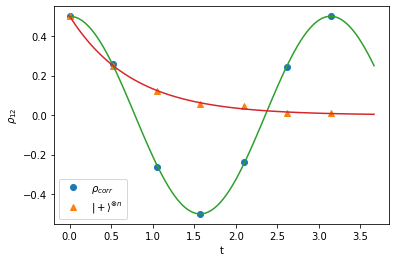

In [8]:
job_corr = execute(correlated_circuits, backend=simulator, shots = SHOTS)
job_sep = execute(separable_circuits, backend=simulator, shots = SHOTS)

result = job_corr.result()
    
r = len(result.results)
    
tp = np.arange(r)*tau
cp = [coherence(result.get_counts(res)) for res in range(r)]

plt.plot(tp, cp, 'o', label='$\\rho_{corr}$')

result = job_sep.result()
r = len(result.results)
    
tp = np.arange(r)*tau
cp = [coherence(result.get_counts(res)) for res in range(r)]
plt.plot(tp, cp, '^', label='$|+\\rangle^{\\otimes n}$')

# Theoretical prediction
t =  np.linspace(0, nmax * tau, 100)

sim_coherence_ghz = 1/2 * (np.cos(g*t)**2 - np.sin(g*t)**2)
sim_coherence_plus = 1/2 * np.cos(2 *g *tau)**(t/tau)

plt.plot(t, sim_coherence_ghz)
plt.plot(t, sim_coherence_plus)

plt.xlabel('t')
plt.ylabel('$\\rho_{12}$')
plt.legend();

### 3. Execution on the real device <a id="execution" />

In [10]:
# Run the calibration job for the ibmqx2 job
cal_circuits, state_labels = complete_meas_cal([system_corr], q, c)
calibration_job = execute(cal_circuits, ibmqx2, shots=SHOTS)

job_corr = execute(correlated_circuits, ibmqx2, shots=SHOTS)
job_sep = execute(separable_circuits, ibmq_16_melbourne, shots=SHOTS)

experiment_data = [{
    "backend": ibmqx2.name(),
    "calibration": calibration_job.job_id(),
    "description": "Circuits for the collisional model with correlated state",
    "jobs": [{'jobid': job_corr.job_id(),
              'description': '$\\rho_{corr}$',
              'metadata': {'g': g, 'tau': tau}
             }]
    },
    {
    "backend": ibmq_16_melbourne.name(),
    "calibration": None,
    "description": "Circuits for the collisional model with separable state",
    "jobs": [{'jobid': job_sep.job_id(),
              'description': '$|+\\rangle^{\\otimes n}$',
              'metadata': {'g': g, 'tau': tau}
             }]
    }
]

filename = 'collisional_model_{}.json'.format(
            datetime.now().strftime(("%Y_%m_%d-%H_%M")))

with open(filename,'w') as file:
    json.dump(experiment_data, file)

All the information about the experiment is stored in a JSON file called `depolarizing_channel_DATETIME.json`.

### 4. Analysis of the results <a id="analysis"/>
#### Instructions:
Use the `filename` variable to load the JSON file containing the experiment information

In [11]:
# List the available experiment files

import glob

print("Available experiment files:")
for f in glob.glob('*.json'):
    print(f)

Available experiment files:
collisional_model_2019_10_11-14_19.json


In [14]:
filename = "collisional_model_2019_10_11-14_19.json"

with open(filename, 'r') as file:
    experiment_data = json.load(file)

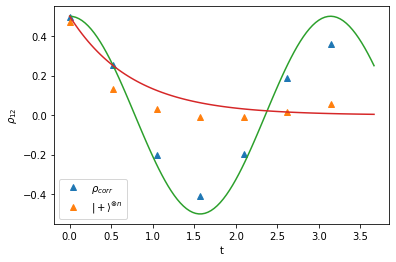

In [23]:
for experiment in experiment_data:

    backend = IBMQ.get_provider().get_backend(experiment['backend'])
    
    job = backend.retrieve_job(experiment['jobs'][0]['jobid'])

    result = job.result()

    if experiment['calibration']:
        # Calibration part
        calibration_job = backend.retrieve_job(experiment['calibration'])

        _, state_labels = complete_meas_cal([2], q, c)

        meas_fitter = CompleteMeasFitter(
            calibration_job.result(),
            state_labels)

        mitigation_filter = meas_fitter.filter

        result = mitigation_filter.apply(result)

    r = len(result.results)
    
    tp = np.arange(r)*tau
    cp = [coherence(result.get_counts(res)) for res in range(r)]
    
    plt.plot(tp, cp, '^', label=experiment['jobs'][0]['description'])
    

# Theoretical prediction
t =  np.linspace(0, nmax * tau, 100)

sim_coherence_ghz = 1/2 * (np.cos(g*t)**2 - np.sin(g*t)**2)
sim_coherence_plus = 1/2 * np.cos(2 *g *tau)**(t/tau)

plt.plot(t, sim_coherence_ghz)
plt.plot(t, sim_coherence_plus)

plt.xlabel('t')
plt.ylabel('$\\rho_{12}$')
plt.legend();

The job contains info on the gate and measurement error rates

In [24]:
job.properties().qubits

[[Nduv(date=datetime.datetime(2019, 10, 11, 6, 28, 28, tzinfo=tzutc()), name='T1', unit='µs', value=53.73821226900286),
  Nduv(date=datetime.datetime(2019, 10, 11, 6, 29, 40, tzinfo=tzutc()), name='T2', unit='µs', value=22.08140309471692),
  Nduv(date=datetime.datetime(2019, 10, 11, 8, 21, 16, tzinfo=tzutc()), name='frequency', unit='GHz', value=5.100137844650205),
  Nduv(date=datetime.datetime(2019, 10, 11, 6, 28, 1, tzinfo=tzutc()), name='readout_error', unit='', value=0.04180000000000006)],
 [Nduv(date=datetime.datetime(2019, 10, 11, 6, 28, 28, tzinfo=tzutc()), name='T1', unit='µs', value=43.55614389202784),
  Nduv(date=datetime.datetime(2019, 10, 11, 6, 30, 40, tzinfo=tzutc()), name='T2', unit='µs', value=63.07016816114353),
  Nduv(date=datetime.datetime(2019, 10, 11, 8, 21, 16, tzinfo=tzutc()), name='frequency', unit='GHz', value=5.238517817275422),
  Nduv(date=datetime.datetime(2019, 10, 11, 6, 28, 1, tzinfo=tzutc()), name='readout_error', unit='', value=0.15410000000000001)],
 [

In [25]:
job.properties().gates

[Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 10, 11, 6, 33, 32, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[0]),
 Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 10, 11, 6, 33, 32, tzinfo=tzutc()), name='gate_error', unit='', value=0.00286630794899434)], qubits=[0]),
 Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 10, 11, 6, 33, 32, tzinfo=tzutc()), name='gate_error', unit='', value=0.00573261589798868)], qubits=[0]),
 Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 10, 11, 6, 33, 32, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[1]),
 Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 10, 11, 6, 33, 32, tzinfo=tzutc()), name='gate_error', unit='', value=0.012544318387491926)], qubits=[1]),
 Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 10, 11, 6, 33, 32, tzinfo=tzutc()), name='gate_error', unit='', value=0.025088636774983852)], qubits=[1]),
 Gate(gate='u1',